# GAN Getting Started - Monet Style Transfer with CycleGAN

### 1. Description of the Problem/Data
 - In this competition, we are provided with a dataset containing Monet paintings and regular photos.
 - The goal is to use a Tensorflow model to transfer the Monet style to the provided photos.

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from kaggle_datasets import KaggleDatasets
import random
import PIL
from PIL import Image
import tqdm
import zipfile

### 2. Exploratory Data Analysis (EDA)

In [15]:
# Try Enabling TPU acceleration
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [16]:
# Set data paths
GCS_PATH = '/kaggle/input/gan-getting-started'
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))
print('Monet images count:', len(MONET_FILENAMES))
print('Photo images count:', len(PHOTO_FILENAMES))

Monet images count: 300
Photo images count: 7038


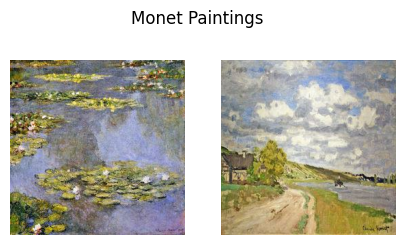

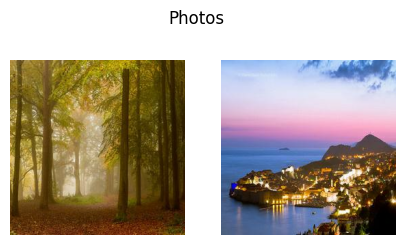

In [17]:
# Display sample images

def display_samples(dataset, title):
    plt.figure(figsize=(5,5))
    for i, image in enumerate(dataset.take(2)):
        plt.subplot(2,2,i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

def decode_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

monet_ds = tf.data.Dataset.from_tensor_slices(MONET_FILENAMES)
monet_ds = monet_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)

photo_ds = tf.data.Dataset.from_tensor_slices(PHOTO_FILENAMES)
photo_ds = photo_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)

display_samples(monet_ds, "Monet Paintings")
display_samples(photo_ds, "Photos")

### 3. Analysis (Model Building and Training)

In [18]:
IMG_HEIGHT = IMG_WIDTH = 256
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 1

def preprocess_image(image):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image - 127.5) / 127.5
    return image

monet_ds = monet_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
photo_ds = photo_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

monet_ds = monet_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
photo_ds = photo_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
with strategy.scope():
    OUTPUT_CHANNELS = 3

    class InstanceNormalization(tf.keras.layers.Layer):
        def __init__(self, epsilon=1e-5):
            super(InstanceNormalization, self).__init__()
            self.epsilon = epsilon

        def build(self, input_shape):
            self.gamma = self.add_weight(
                shape=(input_shape[-1],),
                initializer='ones',
                trainable=True)
            self.beta = self.add_weight(
                shape=(input_shape[-1],),
                initializer='zeros',
                trainable=True)

        def call(self, x):
            mean, variance = tf.nn.moments(x, axes=[1,2], keepdims=True)
            inv = tf.math.rsqrt(variance + self.epsilon)
            normalized = (x - mean) * inv
            return self.gamma * normalized + self.beta

    def downsample(filters, size, apply_instancenorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                       kernel_initializer=initializer, use_bias=False))
        if apply_instancenorm:
            result.add(InstanceNormalization())
        result.add(keras.layers.LeakyReLU())
        return result

    def upsample(filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = keras.Sequential()
        result.add(keras.layers.Conv2DTranspose(filters, size, strides=2,
                                                padding='same',
                                                kernel_initializer=initializer,
                                                use_bias=False))
        result.add(InstanceNormalization())
        if apply_dropout:
            result.add(keras.layers.Dropout(0.5))
        result.add(keras.layers.ReLU())
        return result

    def Generator():
        inputs = keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
        down_stack = [
            downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
            downsample(128, 4),  # (bs, 64, 64, 128)
            downsample(256, 4),  # (bs, 32, 32, 256)
            downsample(512, 4),  # (bs, 16, 16, 512)
            downsample(512, 4),  # (bs, 8, 8, 512)
            downsample(512, 4),  # (bs, 4, 4, 512)
            downsample(512, 4),  # (bs, 2, 2, 512)
            downsample(512, 4),  # (bs, 1, 1, 512)
        ]

        up_stack = [
            upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
            upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
            upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
            upsample(512, 4),  # (bs, 16, 16, 1024)
            upsample(256, 4),  # (bs, 32, 32, 512)
            upsample(128, 4),  # (bs, 64, 64, 256)
            upsample(64, 4),   # (bs, 128, 128, 128)
        ]

        initializer = tf.random_normal_initializer(0., 0.02)
        last = keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='tanh')  # (bs, 256, 256, 3)

        x = inputs
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])

        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = keras.layers.Concatenate()([x, skip])
        x = last(x)
        return keras.Model(inputs=inputs, outputs=x)

    def Discriminator():
        initializer = tf.random_normal_initializer(0., 0.02)
        inp = keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
        x = inp
        x = downsample(64, 4, False)(x)
        x = downsample(128, 4)(x)
        x = downsample(256, 4)(x)
        zero_pad1 = keras.layers.ZeroPadding2D()(x)
        conv = keras.layers.Conv2D(512, 4, strides=1,
                                   kernel_initializer=initializer,
                                   use_bias=False)(zero_pad1)
        norm1 = InstanceNormalization()(conv)
        leaky_relu = keras.layers.LeakyReLU()(norm1)
        zero_pad2 = keras.layers.ZeroPadding2D()(leaky_relu)
        last = keras.layers.Conv2D(1, 4, strides=1,
                                   kernel_initializer=initializer)(zero_pad2)
        return keras.Model(inputs=inp, outputs=last)

    monet_generator = Generator()  # transforms photos to Monet-esque paintings
    photo_generator = Generator()  # transforms Monet paintings to photos

    monet_discriminator = Discriminator()  # differentiates real Monet paintings and generated ones
    photo_discriminator = Discriminator()  # differentiates real photos and generated ones

    class CycleGAN(keras.Model):
        def __init__(self,
                     monet_generator, photo_generator,
                     monet_discriminator, photo_discriminator,
                     lambda_cycle=10):
            super(CycleGAN, self).__init__()
            self.m_gen = monet_generator
            self.p_gen = photo_generator
            self.m_disc = monet_discriminator
            self.p_disc = photo_discriminator
            self.lambda_cycle = lambda_cycle

        def compile(self,
                    m_gen_optimizer, p_gen_optimizer,
                    m_disc_optimizer, p_disc_optimizer,
                    gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
            super(CycleGAN, self).compile()
            self.m_gen_optimizer = m_gen_optimizer
            self.p_gen_optimizer = p_gen_optimizer
            self.m_disc_optimizer = m_disc_optimizer
            self.p_disc_optimizer = p_disc_optimizer
            self.gen_loss_fn = gen_loss_fn
            self.disc_loss_fn = disc_loss_fn
            self.cycle_loss_fn = cycle_loss_fn
            self.identity_loss_fn = identity_loss_fn

        def train_step(self, batch_data):
            real_monet, real_photo = batch_data

            with tf.GradientTape(persistent=True) as tape:
                fake_monet = self.m_gen(real_photo, training=True)
                cycled_photo = self.p_gen(fake_monet, training=True)

                fake_photo = self.p_gen(real_monet, training=True)
                cycled_monet = self.m_gen(fake_photo, training=True)

                same_monet = self.m_gen(real_monet, training=True)
                same_photo = self.p_gen(real_photo, training=True)

                disc_real_monet = self.m_disc(real_monet, training=True)
                disc_real_photo = self.p_disc(real_photo, training=True)

                disc_fake_monet = self.m_disc(fake_monet, training=True)
                disc_fake_photo = self.p_disc(fake_photo, training=True)

                gen_monet_loss = self.gen_loss_fn(disc_fake_monet)
                gen_photo_loss = self.gen_loss_fn(disc_fake_photo)

                total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet) + \
                                   self.cycle_loss_fn(real_photo, cycled_photo)

                total_gen_monet_loss = gen_monet_loss + \
                                       total_cycle_loss * self.lambda_cycle + \
                                       self.identity_loss_fn(real_monet, same_monet) * self.lambda_cycle * 0.5

                total_gen_photo_loss = gen_photo_loss + \
                                       total_cycle_loss * self.lambda_cycle + \
                                       self.identity_loss_fn(real_photo, same_photo) * self.lambda_cycle * 0.5

                disc_monet_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
                disc_photo_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

            grads_monet_gen = tape.gradient(total_gen_monet_loss,
                                            self.m_gen.trainable_variables)
            grads_photo_gen = tape.gradient(total_gen_photo_loss,
                                            self.p_gen.trainable_variables)

            grads_monet_disc = tape.gradient(disc_monet_loss,
                                             self.m_disc.trainable_variables)
            grads_photo_disc = tape.gradient(disc_photo_loss,
                                             self.p_disc.trainable_variables)

            self.m_gen_optimizer.apply_gradients(zip(grads_monet_gen,
                                                     self.m_gen.trainable_variables))

            self.p_gen_optimizer.apply_gradients(zip(grads_photo_gen,
                                                     self.p_gen.trainable_variables))

            self.m_disc_optimizer.apply_gradients(zip(grads_monet_disc,
                                                      self.m_disc.trainable_variables))

            self.p_disc_optimizer.apply_gradients(zip(grads_photo_disc,
                                                      self.p_disc.trainable_variables))

            return {
                "monet_gen_loss": total_gen_monet_loss,
                "photo_gen_loss": total_gen_photo_loss,
                "monet_disc_loss": disc_monet_loss,
                "photo_disc_loss": disc_photo_loss
            }

    with strategy.scope():
        def discriminator_loss(real, generated):
            real_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(real), real)
            generated_loss = tf.keras.losses.MeanSquaredError()(tf.zeros_like(generated), generated)
            total_disc_loss = real_loss + generated_loss
            return total_disc_loss * 0.5

        def generator_loss(generated):
            return tf.keras.losses.MeanSquaredError()(tf.ones_like(generated), generated)

        def cycle_loss(real_image, cycled_image):
            loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
            return loss

        def identity_loss(real_image, same_image):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return loss

        monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

        monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

        cycle_gan_model = CycleGAN(
            monet_generator, photo_generator,
            monet_discriminator, photo_discriminator
        )

        cycle_gan_model.compile(
            m_gen_optimizer=monet_generator_optimizer,
            p_gen_optimizer=photo_generator_optimizer,
            m_disc_optimizer=monet_discriminator_optimizer,
            p_disc_optimizer=photo_discriminator_optimizer,
            gen_loss_fn=generator_loss,
            disc_loss_fn=discriminator_loss,
            cycle_loss_fn=cycle_loss,
            identity_loss_fn=identity_loss
        )

# Training the model
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1213s 61s/step - monet_disc_loss: 2.0283 - monet_gen_loss: 11.4508 - photo_disc_loss: 2.0470 - photo_gen_loss: 12.0568


### 4. Result

In [20]:
# Generate Monet-style images from the photos
def generate_images(model, test_input):
    prediction = model(test_input, training=False)
    prediction = (prediction * 127.5 + 127.5)
    return prediction
 
photo_files_ds = tf.data.Dataset.from_tensor_slices(PHOTO_FILENAMES)
photo_images_ds = photo_files_ds.map(decode_image).map(preprocess_image).batch(1)

with zipfile.ZipFile('images.zip', 'w') as img_out:
    for i, img in enumerate(photo_images_ds):
        gen_img = generate_images(monet_generator, img)
        gen_img = tf.squeeze(gen_img, axis=0)
        gen_img = tf.cast(gen_img, tf.uint8)
        img_bytes = tf.io.encode_jpeg(gen_img)
        img_out.writestr(f'{i}.jpg', img_bytes.numpy())

### 5. Discussion/Conclusion
 - In this notebook, we successfully implemented a CycleGAN model to transfer the style of Monet paintings to regular photos.
 - I performed only one epoch since I was unable to acquire a TPU notebook from kaggle. But the notebook contains all the necessary components that were covered in the lessons